# SHAPE enabled-RNA-RNA interaction prediction

## Dependencies

* All dependencies to run this Notebook has been provided in the conda dependeny file.
* The notebook has been tested on Linux 64bit systems with miniconda-3 installed

In [1]:
# Python libs import
import os
import pandas as pd
from subprocess import Popen, PIPE
import subprocess
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
from Bio import SeqIO

In [2]:
# Reference genome datasets for mRNA and splice site extractions
# Can be obtained from NCBI database
# ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/735/GCF_000001735.3_TAIR10/
TAIR_genome = '../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna'
TAIR_gff_NCBI = '../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz'
TAIR_gff = TAIR_gff_NCBI

# Interaction query (U1 snRNA) data
query_id = "ENSRNA049495626-T1-U1"
query_fasta = './data/U1/ENSRNA049495626-T1-U1.fa'
query_react = './data/U1/ENSRNA049495626-T1-U1.react'
query_react_idless = './data/U1/ENSRNA049495626-T1-U1.noid.react'

In [3]:
# IntaRNA configurations

# For using binary from PATH and Conda keep below var empty
PATH_INTARNA = '' #./IntaRNA/src/bin/'
INTARNA_BIN = os.path.join(PATH_INTARNA, 'IntaRNA') 

# IntaRNA parameters needed for producing heatmaps and tables, 
# Important: The temperature is set for Arabidopsis/plants
INTARNA_ARGS = "-n 20 --outOverlap=B --outMode=C --seedBP=5 --temperature 22  --qAccW 0 --qAccL 0 "


In [4]:
# Check intarna version, support for V2.2.0 or later
! $INTARNA_BIN --version

IntaRNA 2.2.0


### Methods to extract exon junctions of single gene from gff file

In [5]:
def gene_gff_to_df(gene_name):
    gene_gff = gene_name+'.gff'
    gzip_cmd = "gunzip -c {} | grep 'gene={};'  > {}".format(TAIR_gff, gene_name, gene_gff)
    #print(gzip_cmd)
    subprocess.call(gzip_cmd, shell=True)

    df_gff = pd.read_csv(gene_gff, sep='\t',header=None,comment="#",
                     names=['seqname','source','feature','start','end','score','strand','frame','attribute'])

    #print(df_gff)
    df_genes = df_gff[df_gff['feature']=='gene']
    if len(df_genes) > 1:
        print ("BIG WARNING: multiple isoforms(?) found & IGNORED for gene", gene_name)
        print ("Genes with same name (isoforms?)")
    #print (df_genes.iloc[:,0:7])
    df_gff_exons = df_gff[df_gff['feature']=='CDS'].sort_values('start')
    df_gff_exons_uniqs = df_gff_exons.drop_duplicates(subset=['start','end']).copy()
    return df_gff_exons_uniqs, df_genes.iloc[0:1]
# Test case:
# gene_gff_to_df('ACT1')

def df_gff_to_bed_fasta(df, gene_name):
    bed_df = df['seqname'].map(str) + '\t' + df['start'].map(str) + '\t' +\
        df['end'].map(str) + '\t' +\
        gene_name+'-'+df.index.map(str) + '\t' +\
        '1\t' + df['strand'].map(str)
    bed_str = '\n'.join(bed_df.values)
    #print(bed_str)
    bed_file = gene_name+'.bed'
    fasta_genes_genomic = gene_name + '-genomic.fa'
    print ('bedtools getfasta on ', fasta_genes_genomic)    
    with open(bed_file, 'w') as bed_out:
        bed_out.write(bed_str)
        
    bed_cmd = 'bedtools getfasta -fi {} -bed {} -fo {} -s -name'.format(
        TAIR_genome, bed_file, fasta_genes_genomic)
    p = Popen(bed_cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    #print(bed_cmd)
    if (err):
        raise RuntimeError('Error in bedtools\n{}\n{}'.format(out, err))
    #print (out)
    
    return fasta_genes_genomic

def compute_relative_locs(df_gff, gene_start, gene_end, strand):
    if (strand == '+'):
        df_gff.loc[:,'relative-start']= df_gff['start'] - gene_start+1
        df_gff.loc[:,'relative-end'] =  df_gff['end'] - gene_start+1
        ret_arr = [(r['relative-start'],r['relative-end']) for ir, r in df_gff.iterrows()]        
        
    elif (strand == '-'):
        df_gff.loc[:,'relative-start']= -df_gff['start'] + gene_end+1
        df_gff.loc[:,'relative-end'] =  -df_gff['end'] + gene_end+1
        ret_arr = [(r['relative-end'],r['relative-start']) for ir, r in df_gff.iterrows()]        
    else:
        raise RuntimeError('Strand type error')
    return sorted(ret_arr)



## Run IntaRNA

### Parse IntaRNA csv interaction spot probabilities outpu

plot_spotprobs
parse_spotprobs


/home/milad/miniconda3/envs/intaSHAPE/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


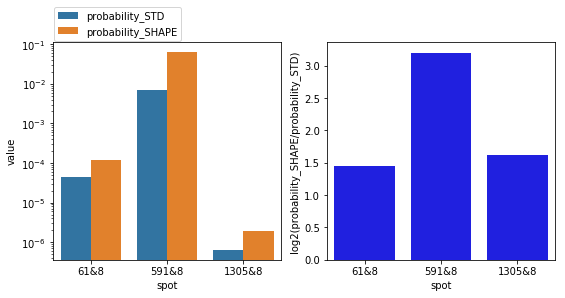

In [6]:
def parse_spotprobs(file1, file2, suffixes=['_STD','_SHAPE'],skip_0_0_spot=True):
    print("parse_spotprobs")
    df1 = pd.read_csv(file1,sep=';')
    df2 = pd.read_csv(file2,sep=';')
    df12 = pd.merge(df1, df2, on='spot', suffixes=suffixes)
    if skip_0_0_spot:
        df12 = df12[df12['spot']!='0&0']
    df12['probability_SHAPE/probability_STD'] = (df12['probability_SHAPE']+1e-50)/(df12['probability_STD']+1e-50)
    df12['log2(probability_SHAPE/probability_STD)'] = np.log2(df12['probability_SHAPE/probability_STD'])
    return df12
def plot_spotprobs(file1, file2,skip_0_0_spot=True,what='both'):
    print("plot_spotprobs")
    dfspotprobs = parse_spotprobs(file1, file2,skip_0_0_spot=skip_0_0_spot)
    
    dfmelt = pd.melt(dfspotprobs,  id_vars =['spot'], value_vars=['probability_STD','probability_SHAPE'])
    if what=='both':
        fig, (ax1,ax2) = plt.subplots(figsize=[9,4],ncols=2)
        sns.barplot(data=dfmelt, x='spot',y='value',hue='variable',ax=ax1)
        ax1.legend(bbox_to_anchor=(0,1.0,1,0.2), loc="lower left",
                #mode="expand", 
                   borderaxespad=0.1)#bbox_to_anchor=(1, 1.2), loc=1, borderaxespad=0.)#(bbox_to_anchor=(1,0), loc="lower right")
        #plt.subplots_adjust(left=0.3,top=0.8)    
        ax1.set_yscale('log')
        sns.barplot(data=dfspotprobs, x='spot',color='b',y='log2(probability_SHAPE/probability_STD)',ax=ax2)
        
    else:
        fig, ax1 = plt.subplots(figsize=[max(3,len(dfspotprobs)),4])
        sns.barplot(data=dfmelt, x='spot',y='value',hue='variable',ax=ax1)
        plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0.1)#bbox_to_anchor=(1, 1.2), loc=1, borderaxespad=0.)#(bbox_to_anchor=(1,0), loc="lower right")
        plt.subplots_adjust(left=0.3,top=0.8)
    
        ax1.set_yscale('log')
        #ax1.set_title(file1)

    return dfspotprobs,fig
    
# Test case:
spotprobs_file1 = 'intarna-spotProbs_ACT1-ENSRNA049495626-T1-U1.csv'
spotprobs_file2 = 'intarna-spotProbs_ACT1-ENSRNA049495626-T1-U1_INTARNASHAPE_.csv'
x =plot_spotprobs(spotprobs_file1, spotprobs_file2,skip_0_0_spot=True,what='both')

In [7]:
sns.barplot?

### Call IntaRNA, extract interaction probabilities and plot heatmap 

In [ ]:
%matplotlib inline

def plot_minE_heatmap(df, exon_regions, figtitle, fig=None, ax=None,
                      plot_selected_exon=None, exon_context_len=100):
    savefig = False
    if (fig is None):
        savefig = True
        fig, ax = plt.subplots(figsize=[20,5])
    mydf = df.iloc[:,1:]#.transpose()
    # mydf[mydf>0] = 'NaN'
    mydf[mydf>0] = None
    [ax.axvspan(ex[0]-1,ex[1]-1, alpha=0.2) for ex in exon_regions]

    sns.heatmap(mydf.transpose(),ax=ax)
    ax.set_ylim(ax.get_ylim()[1],ax.get_ylim()[0])
    
    
    use_custom_ticks=True
    if use_custom_ticks:
        ax.xaxis.set_major_locator(plticker.MultipleLocator(base=500,))
        ax.yaxis.set_major_locator(plticker.MultipleLocator(base=50,))
        majorFormatter = plticker.FormatStrFormatter('%d')
        ax.xaxis.set_major_formatter(majorFormatter)
        ax.yaxis.set_major_formatter(majorFormatter)
    if plot_selected_exon is not None:
        exon_junction = exon_regions[plot_selected_exon][1]
        ax.set_xlim(exon_junction-exon_context_len,exon_junction+exon_context_len+1)
        
    if 'NOSHAPE' in figtitle:
        ax.set_title('STD')
    elif 'SHAPE' in figtitle:
        ax.set_title('SHAPE')
    else:
        ax.set_title('STD')
    if savefig:
        fig.savefig(figtitle+'.png')
    # sns.heatmap(df_SHAPE.iloc[:,1:5],ax=ax)
    
def run_intaRNA_precomputed_access(query_fa, target_fa, query_id, target_id, acc_lunp=None, out_suffix=''):

    # Make a shell command line
    subopt_csv = 'intarna-subopts_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    heatmap_csv = 'intarna-heatmap_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    cmd = 'IntaRNA --target={} --query={} '.format(target_fa, query_fa)
    cmd += '--out=pMinE:{} --out={} '.format(heatmap_csv, subopt_csv)
    params = '{} '.format(INTARNA_ARGS)
    if acc_lunp is not None:
        cmd += '--qAccFile={} '.format(lunp_shape)
        params += '--qAcc=P '
    
    print (cmd, params)
    p = Popen(cmd + params , stdin=PIPE, shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    if err or b"ERROR" in out:
        raise RuntimeError("Error in calling intARNA\n{}\n{}\n".format(out, err))

    #print (out)
    df_subopts = pd.read_csv(subopt_csv,sep=';')
    df_heatmap = pd.read_csv(heatmap_csv,sep=';')

    #df_subopts['intarna_params:{}'.format(params)] = ''
    return  df_subopts, df_heatmap

def run_intaRNA_shape(query_fa, target_fa, query_id, target_id, shape_file=None, out_suffix='',
                      spot_probs_pairs_str=None):

    # Make a shell command line
    subopt_csv = 'intarna-subopts_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    heatmap_csv = 'intarna-heatmap_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    spotprob_csv = 'intarna-spotProbs_{}-{}{}.csv'.format(target_id, query_id, out_suffix)

    cmd = INTARNA_BIN + ' --target={} --query={} '.format(target_fa, query_fa)
    cmd += '--out=pMinE:{} --out={} '.format(heatmap_csv, subopt_csv)
    params = '{} '.format(INTARNA_ARGS)
    
    if shape_file is not None:
        cmd += '--qShape {} '.format(shape_file)
        params += '--qShapeMethod "Z" '
    if spot_probs_pairs_str is not None:
        cmd += '--out="spotProb:{}:{}" '.format(spot_probs_pairs_str, spotprob_csv)
    print (cmd, params)
    p = Popen(cmd + params , stdin=PIPE, shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    if err or b"ERROR" in out:
        raise RuntimeError("Error in calling IntARNA\n{}\n{}\n".format(out, err))

    print (out)
    df_subopts = pd.read_csv(subopt_csv,sep=';')
    df_heatmap = pd.read_csv(heatmap_csv,sep=';')

    #df_subopts['intarna_params:{}'.format(params)] = ''
    return  df_subopts, df_heatmap, spotprob_csv

def truncate_mRNA_to_CDS(fasta_mRNA,exon_regions):
    startcodon_site = min([r[0] for r in exon_regions])
    endcodon_site = max([r[1] for r in exon_regions]) 
    mrna_rec = SeqIO.read(fasta_mRNA,'fasta')
    cds_rec = mrna_rec[startcodon_site-1:endcodon_site]
    cds_rec.id = cds_rec.id+'-CDS-bounded'
    SeqIO.write(cds_rec,fasta_mRNA+'.CDS.fa','fasta')
    truncated_regions = [(r[0]-startcodon_site+1,r[1]-startcodon_site+1) for r in exon_regions]
    return fasta_mRNA+'.CDS.fa', truncated_regions

def run_intarna_shape_for_a_gene(target_gene_name, CDS_only=False,plot_selected_exon=None):
    df_gff_exons, df_genes = gene_gff_to_df(target_gene_name)
    fasta_bed_genomic = df_gff_to_bed_fasta(df_genes, target_gene_name)
    myexon_regions = compute_relative_locs(df_gff_exons, df_genes.iloc[0]['start'], df_genes.iloc[0]['end'],
                      df_genes.iloc[0]['strand'])
    
    # Double check that exons are sorted by rel position
    for i in range(len(myexon_regions)-1):
        assert(myexon_regions[i][0]<=myexon_regions[i+1][0])
    
    if CDS_only:
        target_fasta,myexon_regions = truncate_mRNA_to_CDS(fasta_bed_genomic,myexon_regions)
    else:
        target_fasta = fasta_bed_genomic #'../data/RPS9/RPS9-genomic.fasta'
    uniq_exon_ends = sorted(list(set([ex[1] for ex in myexon_regions])))
    uniq_exon_ends = uniq_exon_ends[:-1] # mRNA end is not considered
    spot_prob_locs = ["{}&8".format(exend+1) for exend in uniq_exon_ends] # Extract exon 3'end
    
    
    mydf_subopts, mydf_heatmap, file_subopts = run_intaRNA_shape(query_fasta, target_fasta, query_id, target_gene_name, 
                                                               spot_probs_pairs_str=','.join(spot_prob_locs))
    mydf_subopts_SHAPE, mydf_heatmap_SHAPE, file_subopts_SHAPE = run_intaRNA_shape(query_fasta, target_fasta, query_id, target_gene_name, 
            shape_file=query_react_idless, out_suffix='_INTARNASHAPE_', 
                                                               spot_probs_pairs_str=','.join(spot_prob_locs))

    myfig, (ax1,ax2) = plt.subplots(figsize=[7,5],nrows=2)
    myfig.tight_layout(rect=[0, 0.1, 1, 0.93])

        
    plot_minE_heatmap(mydf_heatmap, myexon_regions, target_gene_name +'-'+query_id+ '-NOSHAPE', 
                      fig=myfig, ax=ax1, plot_selected_exon=plot_selected_exon)
    plot_minE_heatmap(mydf_heatmap_SHAPE, myexon_regions,target_gene_name + '-'+query_id+'-SHAPE', 
                      fig=myfig, ax=ax2, plot_selected_exon=plot_selected_exon)

    
    myfig.suptitle('mRNA: {}' .format(target_gene_name))
    
    myfig.savefig('heatmap_'+target_gene_name +'-'+query_id+'.png',dpi=600)
    #myfig.savefig('heatmap_'+target_gene_name +'-'+query_id+'.pdf')
    df_spotprobs,fig_spots = plot_spotprobs(file_subopts, file_subopts_SHAPE,what='both')
    df_spotprobs['gene'] = target_gene_name
    fig_spots.savefig('barplot_'+target_gene_name +'-'+query_id+'.png',bbox_to_anchor='tight')
    fig_spots.savefig('barplot_'+target_gene_name +'-'+query_id+'.svg',bbox_to_anchor='tight')
    return df_spotprobs
run_intarna_shape_for_a_gene('RPS9', CDS_only=True,plot_selected_exon=1)

bedtools getfasta on  RPS9-genomic.fa
IntaRNA --target=RPS9-genomic.fa.CDS.fa --query=./data/U1/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_RPS9-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_RPS9-ENSRNA049495626-T1-U1.csv --out="spotProb:340&8:intarna-spotProbs_RPS9-ENSRNA049495626-T1-U1.csv"  -n 20 --outOverlap=B --outMode=C --seedBP=5 --temperature 22  --qAccW 0 --qAccL 0  


## Analyse all mRNAs

In [ ]:
dfs_spotprobs_genes_CDS = list()

for gene in ['ACT1', 'RPS9', 'RPS10','RPL16A','NBR1',]:
    df_spotprobs_gene = run_intarna_shape_for_a_gene(gene,CDS_only=True)
    dfs_spotprobs_genes_CDS.append(df_spotprobs_gene)
    plt.show()
df_spotprobs_genes_CDS = pd.concat(dfs_spotprobs_genes_CDS) 

In [ ]:
df_spotprobs_genes_CDS

In [ ]:
def plot_aggregated_metrics(df_spotprobs,col='log2(probability_SHAPE/probability_STD)',ylim=[-0.9,6]):
    sns.set_style('darkgrid')
    myfig, ax = plt.subplots(figsize=[2.5,4.5])

    sns.boxplot(col,data=df_spotprobs,orient='v',
                #whis=np.inf,
                fliersize=0,ax=ax,
                color='y')
    #sns.stripplot(col,data=df_spotprobs,color=".3",orient='v',jitter=True)
    mean, median = df_spotprobs[col].mean(),df_spotprobs[col].median()
    meanl, medianl = [str(np.round(s, 2)) for s in [mean, median]]
    
    pos = range(1)
    tick,label = 0,ax.get_xticklabels()
#     ax.text(pos[tick], median+0.5, meanl, 
#             horizontalalignment='center', size='small', color='w', weight='semibold')
    ax.text(pos[tick], median+0.1, medianl, 
            horizontalalignment='center', color='k', weight='semibold')
    plt.ylim(ylim)
    plt.savefig('boxplot_all_{}.svg'.format(col.replace('/','-')))
    plt.show()

plot_aggregated_metrics(df_spotprobs_genes_CDS)
plot_aggregated_metrics(df_spotprobs_genes_CDS,col='probability_SHAPE/probability_STD',ylim=[-1,40])